In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [2]:
BA_US_knn_text = pd.read_csv('knnData/BA_US_knn_text.csv')
BA_US_knn_text.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,user_id,appearance,aroma,palate,taste,overall,rating,text,avg,user_state,beer_state
0,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,4.4,n2185.211743,2.5,4.00,4.0,3.75,3.75,3.76,NaN,3.76,North Carolina,Wisconsin
1,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,4.6,n2185.211743,3.0,3.75,4.0,3.50,3.50,3.58,NaN,3.58,North Carolina,Wisconsin


In [3]:
print(BA_US_knn_text.shape)
df_drop = BA_US_knn_text.dropna().reset_index()
print(df_drop.shape)

(6331638, 17)
(1829363, 18)


In [4]:
df_reduced = df_drop[['style', 'appearance', 'aroma', 'palate',
                             'taste', 'overall', 'avg', 'user_state']]
print(df_reduced.shape)
df_reduced.head(2)

(1829363, 8)


,style,appearance,aroma,palate,taste,overall,avg,user_state
0,Munich Helles Lager,4.00,4.00,3.5,3.50,4.00,3.5,Wisconsin
1,Munich Helles Lager,3.25,3.25,3.5,3.25,3.25,3.5,Arizona


In [24]:
states = df_reduced['user_state'].unique().tolist()
states.sort()
states

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [6]:
#states = ['Hawaii', 'Colorado','Maryland','Massachusetts','Michigan']

In [26]:
states = df_reduced['user_state'].unique().tolist() #50 states
states.sort()
states

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [7]:
styles = df_reduced['style'].unique().tolist()
styles.sort()
styles   #103 styles

['Altbier',
 'American Adjunct Lager',
 'American Amber / Red Ale',
 'American Amber / Red Lager',
 'American Barleywine',
 'American Black Ale',
 'American Blonde Ale',
 'American Brown Ale',
 'American Dark Wheat Ale',
 'American Double / Imperial IPA',
 'American Double / Imperial Pilsner',
 'American Double / Imperial Stout',
 'American IPA',
 'American Malt Liquor',
 'American Pale Ale (APA)',
 'American Pale Lager',
 'American Pale Wheat Ale',
 'American Porter',
 'American Stout',
 'American Strong Ale',
 'American Wild Ale',
 'Baltic Porter',
 'Belgian Dark Ale',
 'Belgian IPA',
 'Belgian Pale Ale',
 'Belgian Strong Dark Ale',
 'Belgian Strong Pale Ale',
 'Berliner Weissbier',
 'Bière de Champagne / Bière Brut',
 'Bière de Garde',
 'Black & Tan',
 'Bock',
 'Braggot',
 'California Common / Steam Beer',
 'Chile Beer',
 'Cream Ale',
 'Czech Pilsener',
 'Doppelbock',
 'Dortmunder / Export Lager',
 'Dubbel',
 'Dunkelweizen',
 'Eisbock',
 'English Barleywine',
 'English Bitter',
 'En

In [9]:
def calc_features(style, df, tot_number_reviews):
    
    avg_appearance = df['appearance'].mean()
    avg_aroma = df['aroma'].mean()
    avg_palate = df['palate'].mean()
    avg_taste = df['taste'].mean()
    avg_overall = df['overall'].mean()
    avg_rating = df['avg'].mean()
    std_rating = df['avg'].std()
    review_count = df.shape[0]  #normalize gives us percentage wise, which could be a good feature for style preference
    normalized_review_count = review_count / tot_number_reviews
    
    
    df = pd.DataFrame(columns=['avg_appearance', 'avg_aroma', 'avg_palate', 
                                        'avg_taste', 'avg_overall','avg_rating_per_style',
                                        'std_per_style', 'normalised_review_count'])
    
    df.loc[0] = [avg_appearance,avg_aroma,avg_palate,avg_taste,
                 avg_overall,avg_rating,std_rating,normalized_review_count]
    
    df = df.rename(columns=lambda col: style+'_'+col)
    
    return df
    

In [10]:
df_total_clustering = pd.DataFrame()

for state in states:
    df_state = df_reduced[df_reduced['user_state'] == state]
    
    df_clustering = pd.DataFrame(columns=['user_state'])
    df_clustering.loc[0, 'user_state'] = state
    
    # Add the population for the current state
    #state_population = state_population_df[state_population_df['State'] == state]['Population'].values[0]

    tot_number_reviews = df_state.shape[0]

    for style in styles:
        df_style = df_state[df_state['style'] == style]
        
        if df_style.shape[0] == 0: 
            print("state: ",state)
            print("0 for: ",style)
        
        df_features = calc_features(style, df_style, tot_number_reviews)
        
        df_clustering = pd.concat([df_clustering, df_features], axis=1)
    
    df_total_clustering = pd.concat([df_total_clustering, df_clustering], ignore_index=True)


df_total_clustering.head(3)

state:  Alabama
0 for:  Euro Strong Lager
state:  Alabama
0 for:  Faro
state:  Alabama
0 for:  Gueuze
state:  Alabama
0 for:  Japanese Rice Lager
state:  Alabama
0 for:  Kvass
state:  Alabama
0 for:  Lambic - Unblended
state:  Alaska
0 for:  Euro Strong Lager
state:  Alaska
0 for:  Faro
state:  Alaska
0 for:  Japanese Rice Lager
state:  Arizona
0 for:  Euro Strong Lager
state:  Arizona
0 for:  Faro
state:  Arizona
0 for:  Japanese Rice Lager
state:  Arizona
0 for:  Kvass
state:  Arkansas
0 for:  Bière de Champagne / Bière Brut
state:  Arkansas
0 for:  Euro Strong Lager
state:  Arkansas
0 for:  Faro
state:  Arkansas
0 for:  Gueuze
state:  Arkansas
0 for:  Japanese Rice Lager
state:  Arkansas
0 for:  Kvass
state:  California
0 for:  Kvass
state:  Colorado
0 for:  Euro Strong Lager
state:  Colorado
0 for:  Faro
state:  Connecticut
0 for:  Faro
state:  Connecticut
0 for:  Japanese Rice Lager
state:  Delaware
0 for:  Euro Pale Lager
state:  Delaware
0 for:  Euro Strong Lager
state:  Delawar

,user_state,Altbier_avg_appearance,Altbier_avg_aroma,Altbier_avg_palate,Altbier_avg_taste,Altbier_avg_overall,Altbier_avg_rating_per_style,Altbier_std_per_style,Altbier_normalised_review_count,American Adjunct Lager_avg_appearance,...,Winter Warmer_std_per_style,Winter Warmer_normalised_review_count,Witbier_avg_appearance,Witbier_avg_aroma,Witbier_avg_palate,Witbier_avg_taste,Witbier_avg_overall,Witbier_avg_rating_per_style,Witbier_std_per_style,Witbier_normalised_review_count
0,Alabama,4.058824,3.735294,3.764706,3.911765,3.955882,3.745882,0.252365,0.001860,2.879412,...,0.276159,0.007441,3.597561,3.573171,3.474085,3.429878,3.568598,3.557256,0.282003,0.017947
1,Alaska,3.869048,3.559524,3.583333,3.642857,3.738095,3.695714,0.217499,0.004418,2.973404,...,0.237782,0.010520,3.891791,3.723881,3.817164,3.798507,3.902985,3.763881,0.251342,0.014096
2,Arizona,3.677326,3.500000,3.546512,3.587209,3.622093,3.671395,0.213167,0.004316,3.019345,...,0.216654,0.014051,3.576284,3.574773,3.552870,3.559668,3.577795,3.568489,0.329566,0.016610


In [11]:
review_count_sum_first_row = df_total_clustering.loc[0, df_total_clustering.columns.str.endswith('review_count')].sum()
review_count_sum_first_row

1.0

In [12]:
print(df_total_clustering.loc[0, df_total_clustering.columns.str.startswith('Eisbock')])

Eisbock_avg_appearance                  4.0
Eisbock_avg_aroma                       3.5
Eisbock_avg_palate                      3.0
Eisbock_avg_taste                       3.5
Eisbock_avg_overall                     3.5
Eisbock_avg_rating_per_style           3.66
Eisbock_std_per_style                   NaN
Eisbock_normalised_review_count    0.000109
Name: 0, dtype: object


In [13]:
#prep for PCA
user_state = df_total_clustering['user_state']
df_cleaned_drop = df_total_clustering.drop(columns='user_state', axis=1)
#sometimes we get NaN values when we have 0 reviews for a style
#we don't want to fill with 0s because that can mess up the analysis
#so the best we can do is fill with the mean to preserve the size of the df

df_cleaned = df_cleaned_drop.fillna(df_cleaned_drop.mean())

df_cleaned.head(2)

,Altbier_avg_appearance,Altbier_avg_aroma,Altbier_avg_palate,Altbier_avg_taste,Altbier_avg_overall,Altbier_avg_rating_per_style,Altbier_std_per_style,Altbier_normalised_review_count,American Adjunct Lager_avg_appearance,American Adjunct Lager_avg_aroma,...,Winter Warmer_std_per_style,Winter Warmer_normalised_review_count,Witbier_avg_appearance,Witbier_avg_aroma,Witbier_avg_palate,Witbier_avg_taste,Witbier_avg_overall,Witbier_avg_rating_per_style,Witbier_std_per_style,Witbier_normalised_review_count
0,4.058824,3.735294,3.764706,3.911765,3.955882,3.745882,0.252365,0.001860,2.879412,2.608824,...,0.276159,0.007441,3.597561,3.573171,3.474085,3.429878,3.568598,3.557256,0.282003,0.017947
1,3.869048,3.559524,3.583333,3.642857,3.738095,3.695714,0.217499,0.004418,2.973404,2.707447,...,0.237782,0.010520,3.891791,3.723881,3.817164,3.798507,3.902985,3.763881,0.251342,0.014096


In [14]:
print(df_cleaned.loc[0, df_cleaned.columns.str.startswith('Eisbock')])

Eisbock_avg_appearance             4.000000
Eisbock_avg_aroma                  3.500000
Eisbock_avg_palate                 3.000000
Eisbock_avg_taste                  3.500000
Eisbock_avg_overall                3.500000
Eisbock_avg_rating_per_style       3.660000
Eisbock_std_per_style              0.255609
Eisbock_normalised_review_count    0.000109
Name: 0, dtype: float64


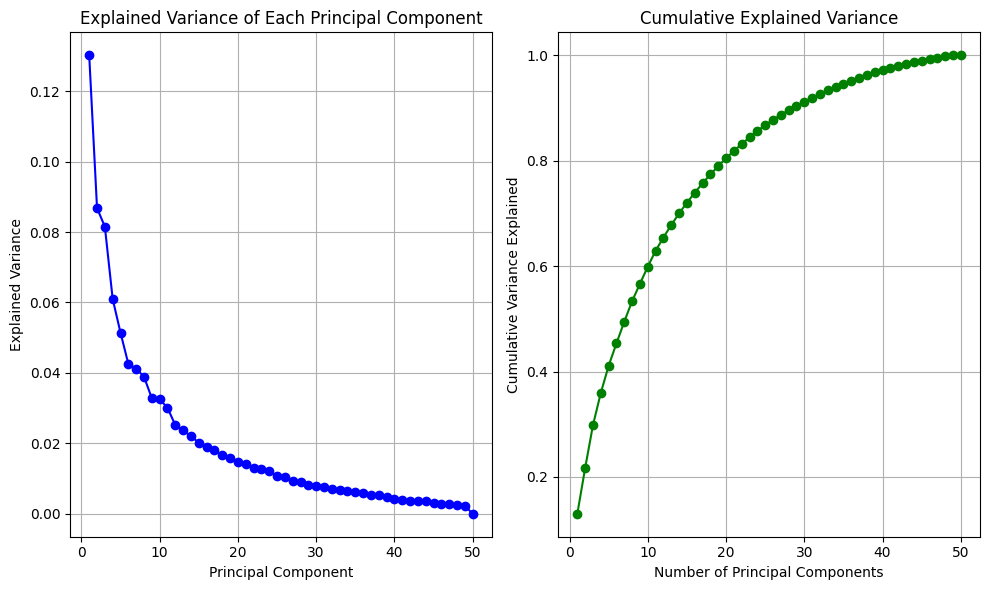

In [17]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)
pca = PCA()
pca.fit(df_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.title('Explained Variance of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
#90% variance explained
n_components_90 = next(i for i, cum_var in enumerate(cumulative_variance) if cum_var >= 0.9) + 1
print(n_components_90)
n_components_95 = next(i for i, cum_var in enumerate(cumulative_variance) if cum_var >= 0.95) + 1
print(n_components_95)
n_components_99 = next(i for i, cum_var in enumerate(cumulative_variance) if cum_var >= 0.99) + 1
print(n_components_99)

pca = PCA(n_components=n_components_90)
df_pca = pca.fit_transform(df_scaled)


29
36
46


In [19]:

#we cluster on the reduced set, choosing how many clusters we expect to get
kmeans = KMeans(n_clusters=10, random_state=42)
df_pca_clusters = kmeans.fit_predict(df_pca)

c:\Users\Enzo\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [20]:


# Create a DataFrame for clusters with state information
df_clustered = pd.DataFrame({
    'state': df_total_clustering['user_state'],  # Assuming 'user_state' column holds the state names
    'cluster': df_pca_clusters
})

# Group by cluster and list states in each
clusters_to_states = df_clustered.groupby('cluster')['state'].apply(list)

# Optionally, convert it to a dictionary
clusters_dict = clusters_to_states.to_dict()

# Print clusters and their states
for cluster, states in clusters_dict.items():
    print(f"Cluster {cluster}:")
    print(states)
    print()

Cluster 0:
['Alaska', 'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Vermont']

Cluster 1:
['Alabama', 'Arkansas', 'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Tennessee', 'Virginia', 'West Virginia']

Cluster 2:
['Utah']

Cluster 3:
['South Dakota']

Cluster 4:
['Arizona', 'California', 'Colorado', 'Florida', 'Hawaii', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 'Nebraska', 'Nevada', 'New Mexico', 'Oregon', 'Texas', 'Washington', 'Wisconsin']

Cluster 5:
['Idaho']

Cluster 6:
['Montana']

Cluster 7:
['Delaware']

Cluster 8:
['North Dakota']

Cluster 9:
['Wyoming']



In [21]:
import plotly.express as px
import pandas as pd

# Step 1: Perform PCA to reduce the data to 3 dimensions
pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df_pca)  # Assuming df_pca is already the reduced data

# Step 2: Create a DataFrame with the PCA components, clusters, and state labels
df_pca_3d_df = pd.DataFrame(df_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d_df['Cluster'] = df_pca_clusters  # Add the cluster labels to the DataFrame
df_pca_3d_df['State'] = df_total_clustering['user_state'].values  # Assuming 'user_state' is the column with state labels

# Step 3: Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df_pca_3d_df, x='PC1', y='PC2', z='PC3', color='Cluster', 
                    title="3D PCA with Clusters", 
                    labels={'State': 'State'},
                    hover_data={'State': True, 'PC1': False, 'PC2': False, 'PC3': False, 'Cluster': False}) 

# Show the plot
fig.show()
